In [70]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 2559, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
^Cceiving objects:   3% (77/2559)
fetch-pack: unexpected disconnect while reading sideband packet


In [ ]:
cd XAI-course_2021/Images/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load Dataset
import torchvision
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=None)
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

<img src='./images/MnistExamples.png' width="50%" height="50%">

In [ ]:
# Load the model
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        return x
        
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

In [ ]:
image = MNIST_x_data_train[80:81].transpose(1,2,0)
plt.imshow(image[:,:,0],cmap='gray')

with torch.no_grad():
    pred = MNIST_CNN(torch.tensor(image/255).permute(2,0,1).unsqueeze(0).float())
print('prediction: ',np.argmax(pred.numpy()))
print('probability: ',pred.numpy()[0,8])
print('correct label: ', MNIST_y_data_train[80])

## Intgrad

<img src='./images/intgrad_expl.png' width="50%" height="50%">
<img src='./images/intgrad_eq.png' width="50%" height="50%">

In [ ]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[80:81]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor(image/255).float()

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN(image.unsqueeze(0))

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, 8, 'black', preprocessing, predict, model_type='pytorch').reshape(28,28)

plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

In [ ]:
!pip install lime

<img src='./images/lime_expl.png' width="50%" height="50%">

In [ ]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 80

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, num_samples=1000)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0])
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

In [ ]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[idx].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=1, max_dist=2)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [ ]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 80

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, segmentation_fn, num_samples=1000)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

In [ ]:
lime_score = explanation.heatmap

## RISE

<img src='./images/rise_expl.png' width="50%" height="50%">

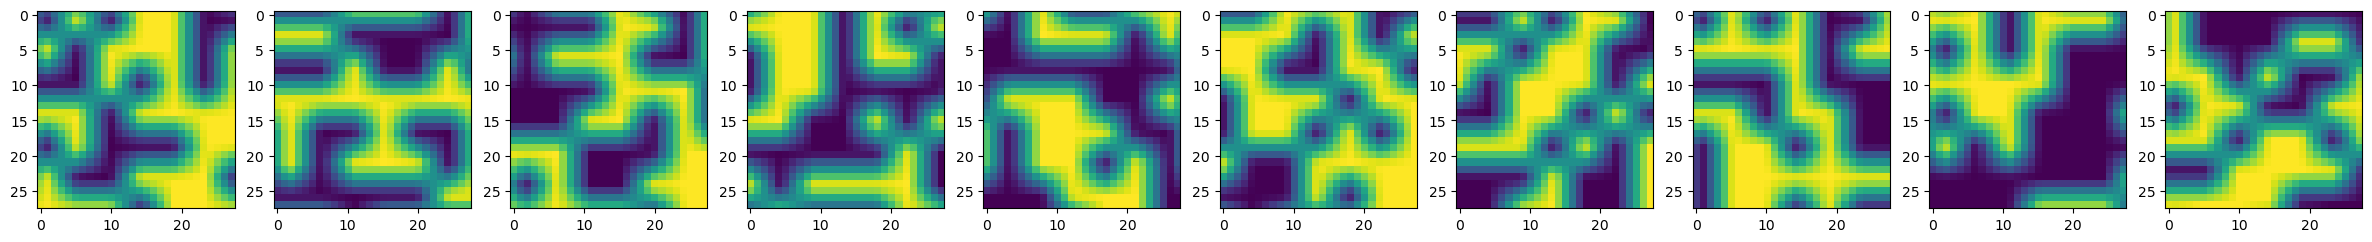

In [ ]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, images):
        return self.model(torch.tensor(images).reshape(-1,1,28,28).float()/255).detach().numpy()
        

model = Rise_model_wrapper(MNIST_CNN, (28,28))
rise = RiseXAIImageExplainer(model)
        

N = 10 # number of random masks
s = 8 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

F,ax=plt.subplots(1,10,figsize=(30,5))
for i in range(10):
    ax[i].imshow(rise.masks[i,:].reshape(28,28))

(10, 28, 28)


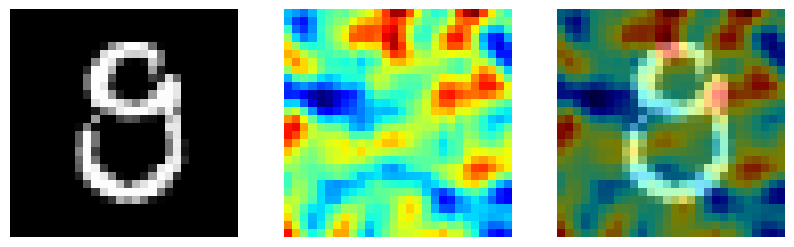

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = MNIST_x_data_train[80,:]
N = 5000
s = 10
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img.reshape(28,28,1)/255)
print(sal.shape)
rise_score = sal[MNIST_y_data_test[8]]

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(rise_score,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(rise_score,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM
Weight the 2D activations by the average gradient

In [ ]:
!pip install ttach

In [ ]:
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

<img src='./images/gradcam_expl.png' width="50%" height="50%">

In [ ]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMImageExplainer(MNIST_CNN)

explainer.fit([list(MNIST_CNN.modules())[-15]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 8, model_type='pytorch')
gradcam_pt_score = attr[0,:]

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM++
Like GradCAM but uses second order gradients

In [ ]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[80,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN)

explainer.fit([list(MNIST_CNN.modules())[-15]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [ ]:
methods = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score]
F, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].axis(False)
    ax[i].imshow(methods[i],cmap='coolwarm')

# Hands-ON Time

# Metrics

In [ ]:
from xailib.metrics.insertiondeletion import ImageInsDel
import torch

# Load the model
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))

# load the image and choose the salicy map you want to analyse
image = MNIST_x_data_train[80:81]

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 28
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

Score: 0.022932921500900053


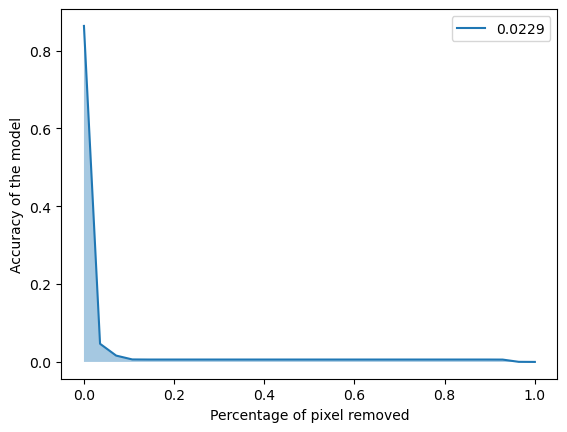

In [ ]:
from sklearn.metrics import auc

y = metric(image, 28, intgrad_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

In [ ]:
[scores,anim] = metric(image, 28, intgrad_pt_score, rgb=False, verbose=1)

In [ ]:
anim

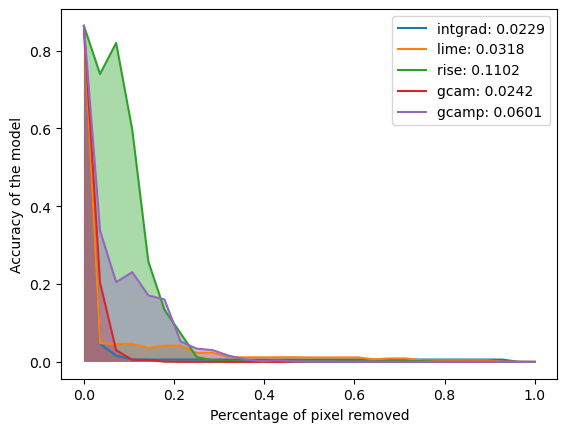

In [74]:
from sklearn.metrics import auc

y_int = metric(image, 28, intgrad_pt_score, rgb=False)
y_lime = metric(image, 28, lime_score, rgb=False)
y_rise = metric(image, 28, rise_score, rgb=False)
y_gcam = metric(image, 28, gradcam_pt_score, rgb=False)
y_gcamp = metric(image, 28, gradcampp_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

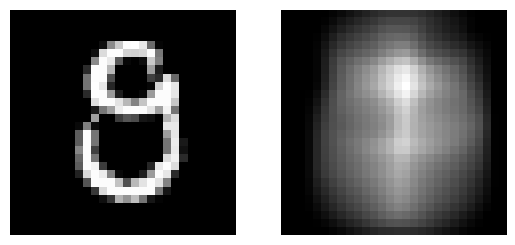

In [77]:
from scipy.ndimage.filters import gaussian_filter
CH = 1
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=11, ksig=5):

    kern = gkern(klen, ksig)
    image = torch.tensor(np.expand_dims(image, 0)).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)[0,:]

F,ax = plt.subplots(1,2)
ax[0].imshow(image[0,:], cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(image)[0,:],cmap='gray')
ax[1].axis(False);

In [80]:
from xailib.metrics.insertiondeletion import ImageInsDel

# load the image and choose your salicy map you want to analyse
image = MNIST_x_data_train[80:81]

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 25
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

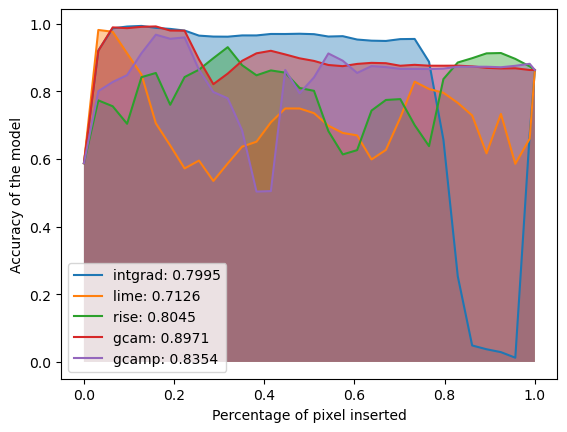

In [81]:
from sklearn.metrics import auc

y_int = metric(image, 28, intgrad_pt_score, rgb=False)
y_lime = metric(image, 28, lime_score, rgb=False)
y_rise = metric(image, 28, rise_score, rgb=False)
y_gcam = metric(image, 28, gradcam_pt_score, rgb=False)
y_gcamp = metric(image, 28, gradcampp_pt_score, rgb=False)
x = np.arange(len(y_int))*step/784
x[-1] = 1.0

for name, y in zip(['intgrad','lime','rise','gcam','gcamp'],[y_int,y_lime,y_rise,y_gcam,y_gcamp]):
    plt.plot(x, y, label=f'{name}: {np.round(auc(x, y),4)}')
    plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel inserted')
plt.ylabel('Accuracy of the model')
plt.legend();

In [82]:
[score,anim] = metric(image, 28, intgrad_pt_score, rgb=False, verbose=1)
anim

# ABELE

### 1) Autoencoder Training

Here we have a script to guide the user to the creation and the training of the autoencoder. 
If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space
- self.discriminator: (only for adversarial autoencoders) take a vector as input and output a class label

In [ ]:
!pip install deap

In [86]:
import sys
import os
import skimage
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import warnings
warnings.filterwarnings('ignore')

#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'mnist'
custom_dataset = False
if not custom_dataset:
    X_train, Y_train, X_test, Y_test, use_rgb = get_dataset(dataset)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_train, ae_name, path_aemodels, dataset)

""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
# ae.fit(X_train, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
# ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
# ae.sample_images(epochs)

' Fit method\n Arguments: \n    X: Dataset to use to train the ae\n    epochs: Epochs to train\n    batch_size\n    sample interval (see before)\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from xailib.explainers.abele_explainer import ABELEImageExplainer
from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'mnist' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
#bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
bb = MNIST_CNN

# defining a functions for bb to return the class index value
def bb_predict(image):
    return np.argmax(MNIST_CNN(torch.tensor(rgb2gray(image/255).reshape(-1,1,28,28)).float()).detach().numpy(),axis=1)
#def bb_predict(X):
#    X = X.astype(float)
#    Y = bb.predict(rgb2gray(X).reshape(-1,28,28,1))   
#    return np.argmax(Y, axis=1)

# load data
X_train, Y_train, X_test, Y_test, _ = get_dataset(dataset)

# load auto encoder
ae = get_autoencoder(X_train, ae_name, path_aemodels, dataset)
ae.load_model()

# index Image 2 Explain
i2e = 80
img = gray2rgb(MNIST_x_data_train[i2e])
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(Y_test)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':ae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':100, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=300, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5]  maximum number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features in the latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)

F, ax = plt.subplots(1,len(proto),figsize=(30,5))
for i in range(len(proto)):
    ax[i].imshow(proto[i]/255)
    ax[i].axis('off')

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars(0.1,True)

if len(counter)==1:
    plt.imshow(counter[0]/255)
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(counter[0])[0]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        ax[i].imshow(counter[i]/255)
        ax[i].axis('off')

In [ ]:
"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Green Points are the ones critical for the prediction, also called exemplars

Yellow points are the ones who change class if activated

White Points are do-nothing points